In [1]:
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from matplotlib import cm
from sklearn.metrics import pairwise_distances

sys.path.insert(1, '/Users/andrewroberts/Desktop/git-repos/gp-calibration/python')
from helper_functions import *
from vsem import *

In [2]:
RANDOM_SEED = 10
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Setup. 

# Number of time steps (days) to simulate model. 
n_year = 3
n_time_step = 365*n_year

# Parameters to calibrate. 
par_cal_names = ["KEXT", "LUE"]

## Latex macros

$$
\newcommand{\state}{x}
\newcommand{\Time}{t}
\newcommand{\timeIdx}{k}
\newcommand{\indexTime}[2][\timeIdx]{{#2}_{#1}}
\newcommand{\firstTimeIdxState}{0}
\newcommand{\firstTimeIdxObs}{1}
\newcommand{\timeInitState}{\indexTime[\firstTimeIdxState]{\Time}}
\newcommand{\timeInitObs}{\indexTime[\firstTimeIdxObs]{\Time}}
\newcommand{\stateInit}{\state_{\firstTimeIdxState}}
\newcommand{\stateInitObs}{\state_{\firstTimeIdxObs}}
\newcommand{\stateApprox}{\hat{\state}}
\newcommand{\timeEnd}{T}
\newcommand{\Ntime}{K} % Number of time steps 
\newcommand{\lastTimeIdx}{\Ntime} % May or may not be equal to \Ntime depending on whether indexing starts from one or zero, etc. 
\newcommand{\timeStep}{h}
\newcommand{\funcODE}{f}
\newcommand{\forcing}{w}
\newcommand{\stateTime}[1][\timeIdx]{\indexTime[{#1}]{\state}}
\newcommand{\forcingTime}[1][\timeIdx]{\indexTime[{#1}]{\forcing}}
\newcommand{\fwdOne}{g} % One-step forward operator (flow map) 
\newcommand{\dimState}{P}
\newcommand{\stateIdx}{p}
\newcommand{\indexState}[2][\stateIdx]{{#2}^{(#1)}}
\newcommand{\stateV}{\state_{\text{v}}}
\newcommand{\stateR}{\state_{\text{r}}}
\newcommand{\stateS}{\state_{\text{s}}}
\newcommand{\dstateV}{\dot{\state}_{\text{v}}}
\newcommand{\dstateR}{\dot{\state}_{\text{r}}}
\newcommand{\dstateS}{\dot{\state}_{\text{s}}}
\newcommand{\NPP}{\textrm{NPP}}
\newcommand{\GPP}{\textrm{GPP}}
\newcommand{\alphaV}{\alpha_{\text{v}}}
\newcommand{\tauV}{\tau_{\text{v}}}
\newcommand{\tauR}{\tau_{\text{r}}}
\newcommand{\tauS}{\tau_{\text{s}}}
\newcommand{\LUE}{\ell}
\newcommand{\LAR}{r}
\newcommand{\KEXT}{\kappa}
\newcommand{\fracRespiration}{\gamma}
\newcommand{\LAI}{\textrm{LAI}}
$$

# The Very Simple Ecosystem Model (VSEM) 


## State Equations 
$$
\begin{align}
\dstateV(\Time) &= \alphaV \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateV(\Time)}{\tauV} \\
\dstateR(\Time) &= (1.0 - \alphaV) \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateR(\Time)}{\tauR} \nonumber \\ 
\dstateS(\Time) &= \frac{\stateR(\Time)}{\tauR} + \frac{\stateV(\Time)}{\tauV} - \frac{\stateS(\Time)}{\tauS}
\end{align}
$$

## Model Driver
$$
\begin{align}
\NPP(\stateV, \forcing) &= (1 - \fracRespiration) \GPP(\stateV, \forcing) \\
\GPP(\stateV, \forcing) &= \forcing \cdot \LUE \cdot \left[1 - \exp\left\{-\KEXT \cdot \LAI(\stateV) \right\} \right] \\
\LAI(\stateV) &= \LAR \cdot \stateV.
\end{align} 
$$

In [4]:
# VSEM Defaults.
par_default = get_vsem_default_pars()
print(par_default)
par_default = par_default["value"].values
print(par_default)

   par_name      value
0      KEXT      0.500
1       LAR      1.500
2       LUE      0.002
3     GAMMA      0.400
4      tauV   1440.000
5      tauS  27370.000
6      tauR   1440.000
7        Av      0.500
8        Cv      3.000
9        Cs     15.000
10       Cr      3.000
[5.000e-01 1.500e+00 2.000e-03 4.000e-01 1.440e+03 2.737e+04 1.440e+03
 5.000e-01 3.000e+00 1.500e+01 3.000e+00]


In [5]:
# Choose Calibration parameters and define priors. 
par_prior = get_vsem_default_priors()
par_cal_idx = np.where(par_prior.par_name.isin(par_cal_names))[0]
par_cal_prior = np.take(par_prior, par_cal_idx, axis=0)
dim_par = len(par_cal_names)
par_cal_prior

,par_name,dist,param1,param2
0,KEXT,Uniform,0.2000,1.000
2,LUE,Uniform,0.0005,0.004


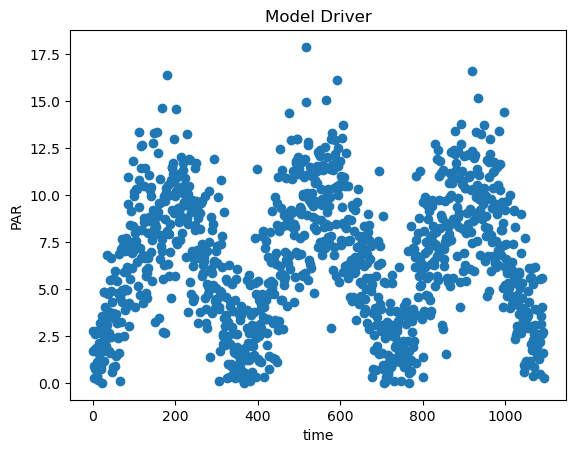

In [6]:
# Forcing/driving data: photosynthetically active radiation. 
# Note that time t here is in days, so t=1 is 1 day and t=365 is 1 year. 
time_steps, model_driver = get_PAR_driver(n_time_step, rng=rng)
plt.plot(time_steps, model_driver, "o")
plt.xlabel("time")
plt.ylabel("PAR")
plt.title("Model Driver")
plt.show()

In [7]:
# Define the observation operator. For convenience, this is broken down in to the 
# composition of a deterministic component and a noise component, but a more complex
# noise model could also be considered. The input to these functions will be the output
# from the function `fwd()` defined above. This will typically be a matrix of shape 
# (number time steps, number output variables).

# def obs_op_annual_mean(fwd_model_output):
#    # This creates annual averages; only works if the number of rows in 
#    # `fwd_model_output` is divisible by 365. 
#    veg_idx = output_names.index("Cv")
#    fwd_model_output = fwd_model_output[:,veg_idx,np.newaxis]
#    n_output = fwd_model_output.shape[1]
#    return fwd_model_output.reshape((-1,365,n_output)).mean(axis=1)

output_names = get_vsem_output_names()
veg_idx = output_names.index("Cv")

# Forward model. 
fwd = get_vsem_fwd_model(model_driver, dim_par, par_cal_idx, par_default, simplify=False)

def obs_op(pred_fwd):
    # The output variable is assumed to be stored in the last dimension. This 
    # accounts for the case where `fwd` is of dimension (N_time_step, N_output)
    # (as in a single model run) or (N_run, N_time_step, N_output) (as in the 
    # case of output from multiple runs). 
    return np.take(pred_fwd, veg_idx, axis=-1)

def param_to_obs_op(par):
    return obs_op(fwd(par))    

In [8]:
# Generate ground truth data and observed data.
signal_to_noise_ratio = 20
par_true = par_default.copy()
par_cal_true = par_true[par_cal_idx]
fwd_true = fwd(par_cal_true)
y_true = obs_op(fwd_true)
sig_eps =  np.mean(y_true) / signal_to_noise_ratio
eps = sp.stats.norm(loc=0, scale=np.sqrt(sig_eps))
y_obs = y_true + eps.rvs(size=y_true.shape, random_state=rng)

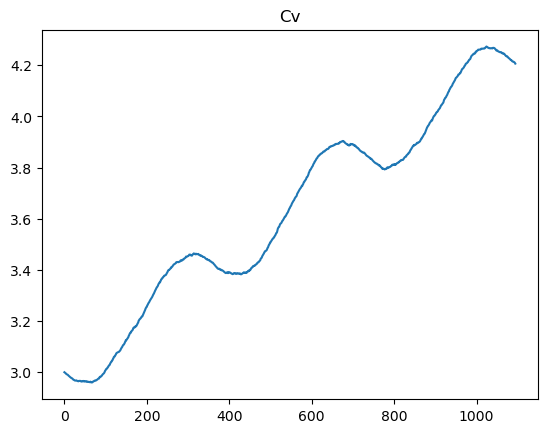

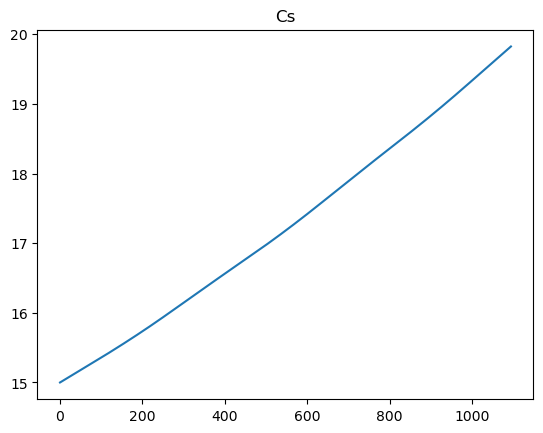

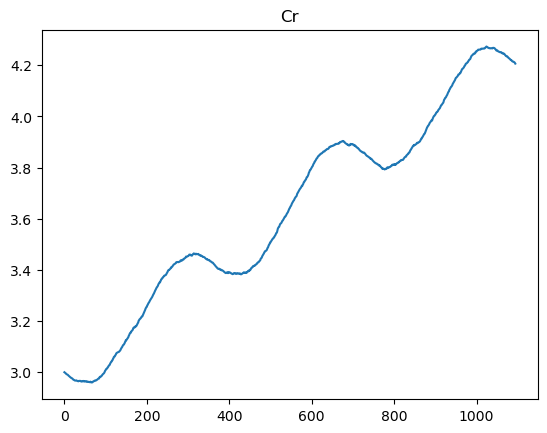

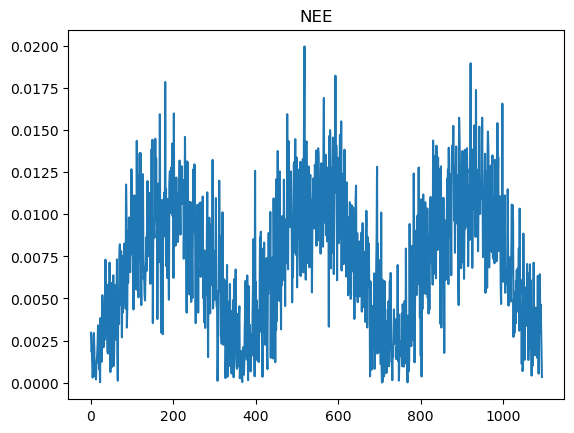

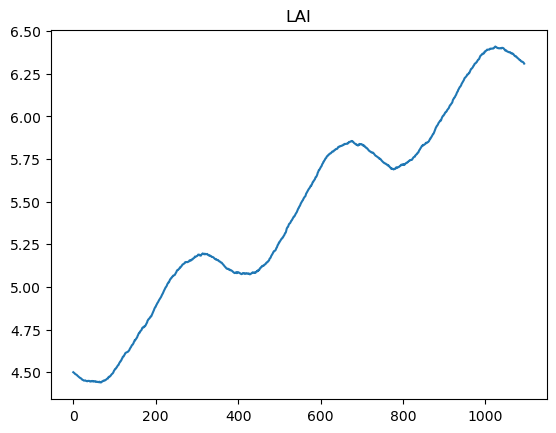

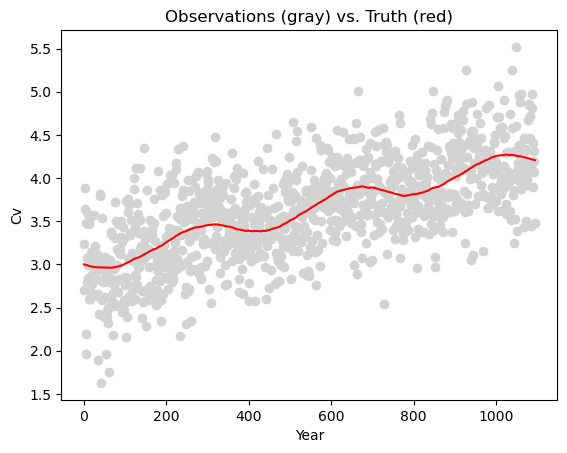

In [9]:
# Model Projections.
for j in range(fwd_true.shape[2]):
    plt.plot(time_steps, fwd_true[0,:,j])
    plt.title(output_names[j])
    plt.show()

# Observations.
plt.plot(time_steps, y_obs.T, marker="o", linestyle="", color="lightgray")
plt.plot(time_steps, y_true.T, color="red")
plt.title("Observations (gray) vs. Truth (red)")
plt.xlabel("Year")
plt.ylabel("Cv")
plt.show()

# Log Prior, Exact Likelihood, and Posterior Density Functions

In [10]:
prior = []
for i in range(dim_par):
    loc = par_cal_prior.param1.values[i]
    scale = par_cal_prior.param2.values[i] - loc
    prior.append(sp.stats.uniform(loc=loc, scale=scale))

In [11]:
def calc_llik(par, y, pred_fwd=None, pred_obs=None):
    # The observations `y` are assume to be of dimension (1,N_time_step). 
    # `param_to_obs_op()` returns array of shape (N_run, N_time_step).
    # This function returns an array of shape (N_run,) containing the 
    # log-likelihood evaluations at each parameter value. 

    # Compute the observable predicted by the model. 
    if pred_obs is None:
        if pred_fwd is None:
            pred_obs = param_to_obs_op(par)
        else:
            pred_obs = obs_op(pred_fwd)
            
    # Evaluate log-likelihood. 
    return eps.logpdf(y-pred_obs).sum(axis=1)

def calc_lprior(par):
    # `par` assumed to be either shape (N_par,) for log prior evaluation at single 
    # point or (N_points, N_par) for prior evaluation at `N_points` points. 
    if par.ndim == 1:
        par = par.reshape((1,-1))
    return np.array([prior[i].logpdf(par[:,i]) for i in range(dim_par)]).sum(axis=0)

def calc_lpost(par, pred_fwd=None, pred_obs=None, llik=None, lprior=None, y=None): 

    # Evaluate log-likelihood. 
    if llik is None:
        llik = calc_llik(par, y, pred_fwd, pred_obs)

    # Evaluate log-prior. 
    if lprior is None:
        lprior = calc_lprior(par)

    return lprior+llik

# Design and Test Points 

In [12]:
# Generate design points based on prior distribution. 
# TODO: for now this is particular to 2d param space, need to generalize. 
n_design = 10
lh_sampler = sp.stats.qmc.LatinHypercube(d=dim_par)
uniform_design = lh_sampler.random(n=n_design)
par_cal_design = np.hstack((prior[0].ppf(uniform_design[:,0]).reshape((n_design,1)), 
                            prior[1].ppf(uniform_design[:,1]).reshape((n_design,1))))

In [13]:
# Generate grid of test points. 
# TODO: I need to be more careful about reshaping between the grid and long format. Should review NumPy broadcasting
# and then write some helper functions. 
n_grid_1d = 50
grid_bounds = np.asarray(par_cal_prior[["param1", "param2"]]).T
x1_grid = np.linspace(grid_bounds[0,0], grid_bounds[1,0], num=n_grid_1d)
x2_grid = np.linspace(grid_bounds[0,1], grid_bounds[1,1], num=n_grid_1d)
x_grid = np.meshgrid(x1_grid, x2_grid)
par_cal_test = np.array([(x1, x2) for x2 in x2_grid for x1 in x1_grid])
n_test = par_cal_test.shape[0]

In [14]:
# Create extrapolation points to test emulator tail behavior. 
n_extrap_points_per_dim = 50
max_extrap_scale = 2
par_design_bounds = get_bounds(par_cal_design)
design_extrap = gen_extrapolation_test_inputs(dim_par, n_extrap_points_per_dim, 
                                              max_scaler=max_extrap_scale, target_bounds=par_design_bounds)
design_extrap_long = design_extrap.reshape((design_extrap.shape[0] * design_extrap.shape[1], 2))
fixed_vals = {par_cal_names[1]:np.unique(design_extrap[0,:,1])[0], par_cal_names[0]:np.unique(design_extrap[1,:,0])[0]}

In [15]:
# Generate llik responses at design and test points.
fwd_design = fwd(par_cal_design)

pred_obs_design = obs_op(fwd_design)
pred_obs_test = param_to_obs_op(par_cal_test)

llik_design = calc_llik(par_cal_design, y_obs, pred_obs=pred_obs_design)
llik_test = calc_llik(par_cal_test, y_obs, pred_obs=pred_obs_test)
llik_extrap = calc_llik(design_extrap_long, y_obs)

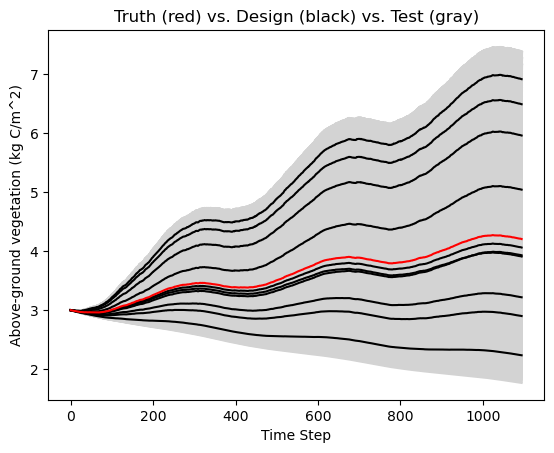

In [16]:
# Plot simulated observables vs. ground truth.
plt.plot(time_steps, pred_obs_test.T, color="lightgray")
plt.plot(time_steps, pred_obs_design.T, color="k")
plt.plot(time_steps, y_true.T, color="red")
plt.xlabel("Time Step")
plt.ylabel("Above-ground vegetation (kg C/m^2)")
plt.title("Truth (red) vs. Design (black) vs. Test (gray)")
plt.show()

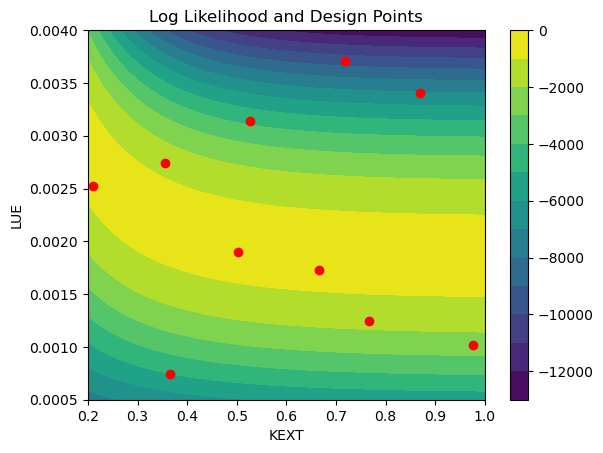

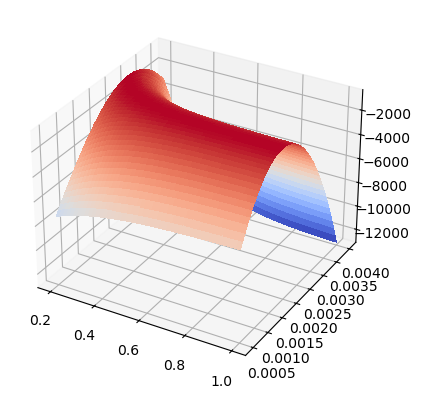

In [17]:
# Contour plot. 
n_levels=14
plt.contourf(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d), levels=n_levels)
plt.colorbar()
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.xlabel(par_cal_names[0])
plt.ylabel(par_cal_names[1])
plt.title("Log Likelihood and Design Points")
plt.show()

# 3d surface plot. 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=x_grid[0], Y=x_grid[1], Z=llik_test.reshape(n_grid_1d, n_grid_1d), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

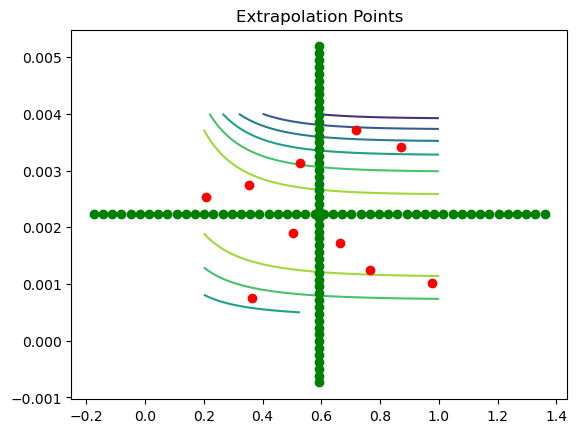

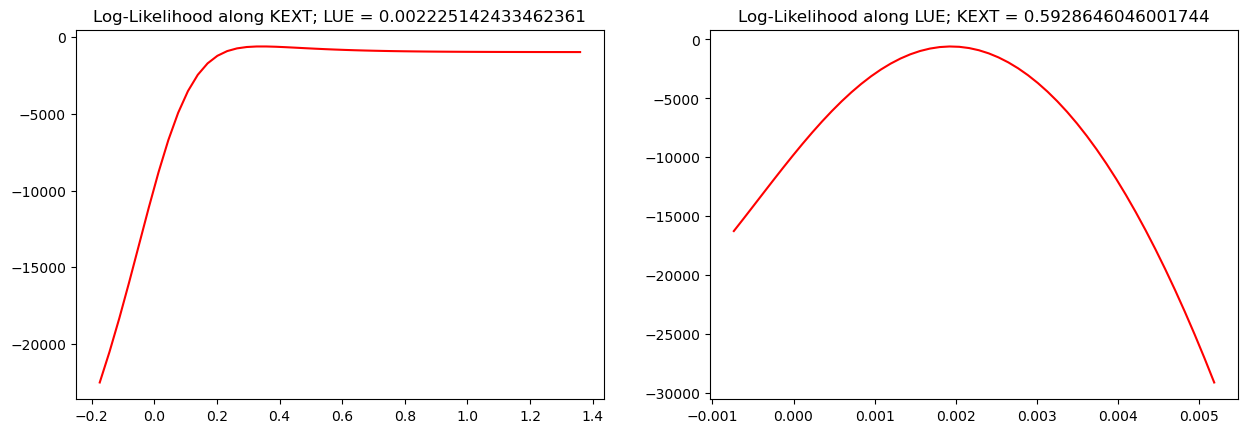

In [18]:
# Contour plot with extrapolation points. 
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d))
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.plot(design_extrap_long[:,0], design_extrap_long[:,1], "og")
plt.title("Extrapolation Points")
plt.show()

# Plot log-likelihood at extrapolation points along each coordinate axis. 
fig = plt.figure()
fig.set_figwidth(15.0)

for j in range(dim_par):
    par_name = par_cal_names[j]
    fixed_par = par_cal_names[(j+1)%2]
    plt.subplot(1,2,j+1)
    start_idx = 0 + j*n_extrap_points_per_dim
    stop_idx = (j+1) * n_extrap_points_per_dim
    plt.plot(design_extrap_long[start_idx:stop_idx,j], llik_extrap[start_idx:stop_idx], "r")
    plt.title("Log-Likelihood along " + par_name + "; " + fixed_par + " = " + str(fixed_vals[fixed_par]))
plt.show()

## Log Likelihood Gaussian Process Emulators: Specifying the Models

### Calculations for Data-Informed GP Hyperparameterization

In [19]:
# Statistics of log-likelihood design. 
llik_max_idx = np.argmax(llik_design)
llik_max = llik_design[llik_max_idx]
llik_rng = llik_max - np.min(llik_design)
llik_std = np.std(llik_design)
llik_mean = np.mean(llik_design)

# Statistics of parameter design. 
par_cal_max = par_cal_design[llik_max_idx,:]
pairwise_dist_ranges = get_pairwise_dist_range_per_dim(par_cal_design)

# Quantities based on prior. 
prior_sd = np.sqrt([p.var() for p in prior])

### Constant Mean, Gaussian Kernel
MAP estimates with empirically determined priors on the hyperparameters.

In [20]:
# Inverse Gamma prior for lengthscale parameters; constrained so that the majority of the 
# mass lies between the minimum and maximum pairwise distances in the design data for 
# each dimension. 
alpha_params = np.empty(dim_par)
beta_params = np.empty(dim_par)
for d in range(dim_par):
    dist_min = pairwise_dist_ranges[0,d]
    dist_max = pairwise_dist_ranges[1,d]
    midpoint = 0.5*(dist_min + dist_max)
    alpha_guess,beta_guess = get_IG_pars_from_mean_sd(midpoint, dist_max-midpoint)
    lengthscale_param = pm.find_constrained_prior(
        pm.InverseGamma, lower=dist_min, upper=dist_max, mass=0.9, 
        init_guess={"alpha":alpha_guess, "beta":beta_guess}
    )
    alpha_params[d] = lengthscale_param["alpha"]
    beta_params[d] = lengthscale_param["beta"]

# Combine into single dictionary.
lengthscale_params = {"alpha":alpha_params, "beta":beta_params}
print(lengthscale_params)

{'alpha': array([3.02084743, 3.26937232]), 'beta': array([0.85516844, 0.00375927])}


In [21]:
# Half-Normal prior for the scale parameter.
upper_bound=0.5*llik_rng
scale_params = pm.find_constrained_prior(
    pm.HalfNormal, lower=0, upper=upper_bound, mass=0.9, 
    init_guess={"sigma":0.5*upper_bound}
)
print(scale_params)

{'sigma': 2678.940077711699}


In [22]:
# For info on combining scaler parameters into a random vector, see here:
# https://discourse.pymc.io/t/declaring-priors-using-loops-for-state-space-models/13819/2
#
# Information on including print statements in the model for debugging purposes is contained 
# here: https://www.pymc.io/projects/examples/en/latest/howto/howto_debugging.html

with pm.Model() as gpModel1:

    # Design data. 
    X_design = pm.Data("X", par_cal_design)
    Y_design = pm.Data("Y", llik_design)

    # Mean function.
    mean_cst = pm.Normal("beta0", mu=llik_mean, sigma=llik_std, shape=1)
    mean_func = pm.gp.mean.Constant(c=mean_cst)

    # Covariance function. 
    scale = pm.HalfNormal("alpha", **scale_params)
    lengthscales = pm.InverseGamma("ell", shape=2, **lengthscale_params)
    cov_func = np.power(scale,2) * pm.gp.cov.ExpQuad(2, ls=lengthscales)

    # Specify the GP.
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noiseless GP.  
    y_ = gp.marginal_likelihood("Y_process", X=X_design, y=Y_design, sigma=0)

### Quadratic Mean, Gaussian Kernel
TODO

### Constant Mean, Quadratic+Gaussian Kernel 

In [23]:
mean_shift_param = pm.find_constrained_prior(
    pm.HalfNormal, lower=0.0, upper=0.2*llik_rng, mass=0.9, init_guess={"sigma": 0.1*llik_rng}
)

quad_offset_param = pm.find_constrained_prior(
    pm.HalfNormal, lower=0.0, upper=0.1*llik_rng, mass=0.9, init_guess={"sigma": 0.05*llik_rng}
)

upper_bound_Gauss=0.2*llik_rng
scale_param_Gauss = pm.find_constrained_prior(
    pm.HalfNormal, lower=0, upper=upper_bound_Gauss, mass=0.9, 
    init_guess={"sigma":0.5*upper_bound_Gauss}
)

In [24]:
with pm.Model() as gpModel2:

    # Design data. 
    X_design = pm.Data("X", par_cal_design)
    Y_design = pm.Data("Y", llik_design)

    # Mean function.
    mean_shift = pm.HalfNormal("mean_shift", **mean_shift_param, shape=1)
    mean_func = pm.gp.mean.Constant(c=llik_max + mean_shift)

    # Covariance function: Quadratic part. 
    quad_shift = pm.MvNormal("s", mu=par_cal_max, cov=np.power(prior_sd,2) * np.eye(dim_par))
    quad_offset = pm.HalfNormal("c", **quad_offset_param, shape=1)
    scaleQ = pm.HalfNormal("alphaQ", sigma=2*scale_param_Gauss["sigma"])
    corr_func_Q = pm.gp.cov.Polynomial(2, c=quad_shift, d=2, offset=quad_offset)
    
    # Covariance function: Gaussian part. 
    scaleG = pm.HalfNormal("alphaG", **scale_param_Gauss)
    lengthscales = pm.InverseGamma("ell", shape=2, **lengthscale_params)
    corr_func_G = pm.gp.cov.ExpQuad(2, ls=lengthscales)

    # Covariance function. 
    cov_func = np.power(scaleQ,2) * corr_func_Q + np.power(scaleG,2) * corr_func_G
    
    # Specify the GP.
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Noiseless GP.  
    y_ = gp.marginal_likelihood("Y_process", X=X_design, y=Y_design, sigma=0)

## Fitting Emulators

In [25]:
# Note on variable transformations during optimization: 
# https://stackoverflow.com/questions/42146962/what-does-the-find-map-output-mean-in-pymc3

with gpModel1:
    hyperpar_estimates1 = pm.find_MAP()

print(hyperpar_estimates1)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'beta0': array([-3318.56754201]), 'alpha_log__': array(8.01300795), 'ell_log__': array([ 0.28454129, -7.13111095]), 'alpha': array(3019.98743771), 'ell': array([1.32915219e+00, 7.99830322e-04])}


In [28]:
with gpModel2:
    hyperpar_estimates2 = pm.find_MAP()

print(hyperpar_estimates2)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'mean_shift_log__': array([1.6493371]), 's': array([0.50856369, 0.00190264]), 'c_log__': array([4.93727745]), 'alphaQ_log__': array(3.39838588), 'alphaG_log__': array(7.79683785), 'ell_log__': array([ 0.14105794, -7.16960808]), 'mean_shift': array([5.20352929]), 'c': array([139.39023532]), 'alphaQ': array(29.91577334), 'alphaG': array(2432.89660547), 'ell': array([1.15149136e+00, 7.69624304e-04])}


## GP Predictions

In [26]:
with gpModel1: 
    pred1 = gp.predict(Xnew=par_cal_test, point=hyperpar_estimates1, diag=True)
    pred1_extrap = gp.predict(Xnew=design_extrap_long, point=hyperpar_estimates1, diag=True)

In [29]:
with gpModel2: 
    pred2 = gp.predict(Xnew=par_cal_test, point=hyperpar_estimates2, diag=True)
    pred2_extrap = gp.predict(Xnew=design_extrap_long, point=hyperpar_estimates2, diag=True)

### Summarize Predictions

In [100]:
# Negatively oriented so that smaller scores are better. 
def calc_crps_Gaussian(y, m, v):
    s = np.sqrt(v)
    y_norm = (y-m)/s
    F = sp.stats.norm.cdf(y_norm)
    f = sp.stats.norm.pdf(y_norm)
    crps = s * (y*(2*F - 1) + 2*f - np.power(np.pi, -0.5))
    return -crps

# Negatively oriented so that smaller scores are better. 
def calc_log_score_Gaussian(y, m, v):
    return -sp.stats.norm.logpdf(y, loc=m, scale=np.sqrt(v))

In [101]:
# Collect mean and variance predictions. 
pred_mean = []
pred_var = []
pred_sd = []

pred_list = [pred1, pred2]
pred_extrap_list = [pred1_extrap, pred2_extrap]
n_models=len(pred_list)
for i in range(len(pred_list)):
    pred_list[i] = {"mean":pred_list[i][0], "var":pred_list[i][1]} 
    pred_extrap_list[i] = {"mean":pred_extrap_list[i][0], "var":pred_extrap_list[i][1]}

In [109]:
# Model evaluation. 
def calc_gp_pointwise_errors(y_pred, y_true):
    m = y_pred["mean"]
    v = y_pred["var"]
    mae = np.abs(m - y_true)
    crps = calc_crps_Gaussian(y_true, m, v)
    log_score = calc_log_score_Gaussian(y_true, m, v)
    return {"mae":mae, "crps":crps, "log_score":log_score}

# Note that this will return NaN if there are non-positive numbers in `x`. 
# TODO: generalize this to allow for mix of negative and positive numbers. 
def weighted_mean(x, log_weights=None, return_log=False):
    if log_weights is None:
        log_weights = 0.0
    
    # LogSumExp for numerically stable weighted average. 
    log_summands = np.log(x) + log_weights
    log_weighted_mean = sp.special.logsumexp(log_summands) - np.log(len(log_summands))
    if return_log:
        return log_weighted_mean
    return np.exp(log_weighted_mean)

def average_pointwise_errors(y_pred, metrics=["mae", "log_score"], log_weights=None, return_log=False):
    mean_metrics = {}
    for metric in metrics:
        mean_metrics[metric] = weighted_mean(y_pred[metric], log_weights=log_weights, return_log=return_log)

    return mean_metrics

In [103]:
for pred in pred_list:
    pred.update(calc_gp_pointwise_errors(pred, llik_test))

In [110]:
# Average errors, unweighted. 
mean_errs = {}
mean_errs ["model1"] = average_pointwise_errors(pred_list[0])
mean_errs2["model2"] = average_pointwise_errors(pred_list[1])
pd.DataFrame(mean_errs2)

,model1,model2
mae,552.335092,599.093901
log_score,12.233674,15.596883


In [75]:
# Average errors, weighted by true likelihood. 
mean_errs = {}
mean_errs["model1"] = average_pointwise_errors(pred_list[0])
mean_errs["model2"] = average_pointwise_errors(pred_list[1])
pd.DataFrame(mean_errs)

,model1,model2
crps,406616.853351,158706.411411
mae,552.335092,599.093901
log_score,-12.233674,-15.596883


In [74]:
# Average errors, weighted to by likelihood. 
mean_errs_wt = {}
mean_errs_wt["model1"] = average_pointwise_errors(pred_list[0], log_weights=llik_test)
mean_errs_wt["model2"] = average_pointwise_errors(pred_list[1], log_weights=llik_test)
pd.DataFrame(mean_errs_wt)

,model1,model2
crps,1.095277e+06,404784.355515
mae,8.742131e+02,727.848808
log_score,-1.738533e+01,-15.509563


In [67]:
# Returning matplotlib figure/axes from function: 
# https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
# https://stackoverflow.com/questions/62612686/how-can-i-return-a-matplotlib-figure-from-a-function


def plot_gp_fit_2d(X_grid, y1, y2, X_points=None, n_levels=10, titles=["y1","y2"]):
    n_grid_1,n_grid_2 = X_grid[0].shape
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,8), sharex='col', sharey='row')
    fig.set_figwidth(15.0)
    (ax1, ax2) = axs
    min_level = np.min([np.min(y1), np.min(y2)])
    max_level = np.max([np.max(y1), np.max(y2)])
    levels = np.linspace(start=min_level, stop=max_level, num=n_levels)

    # Filled contour plot of y1. 
    plt_y1 = ax1.contourf(X_grid[0], X_grid[1], y1.reshape(n_grid_1, n_grid_2), levels=levels)
    ax1.set_title(titles[0])

    # Filled contour plot of y2. 
    plt_y2 = ax2.contourf(X_grid[0], X_grid[1], y2.reshape(n_grid_1, n_grid_2), levels=levels)
    ax2.plot(X_points[:,0], X_points[:,1], "or")
    ax2.set_title(titles[1])

    # Optionally plot set of points. 
    if X_points is not None:
        ax1.plot(X_points[:,0], X_points[:,1], "or")
        ax2.plot(X_points[:,0], X_points[:,1], "or")
        
    plt.tight_layout()
    plt.colorbar(plt_y2, ax=axs)

    return fig
    

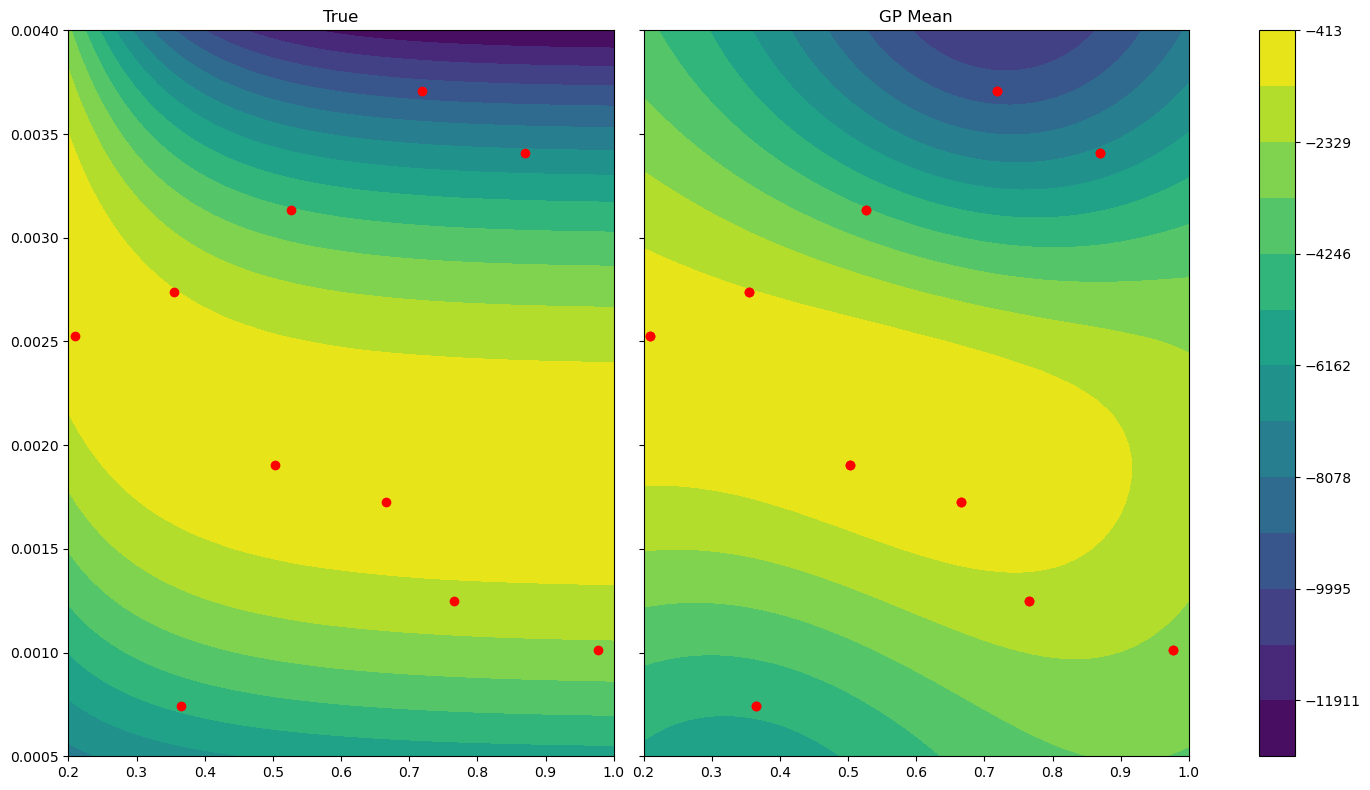

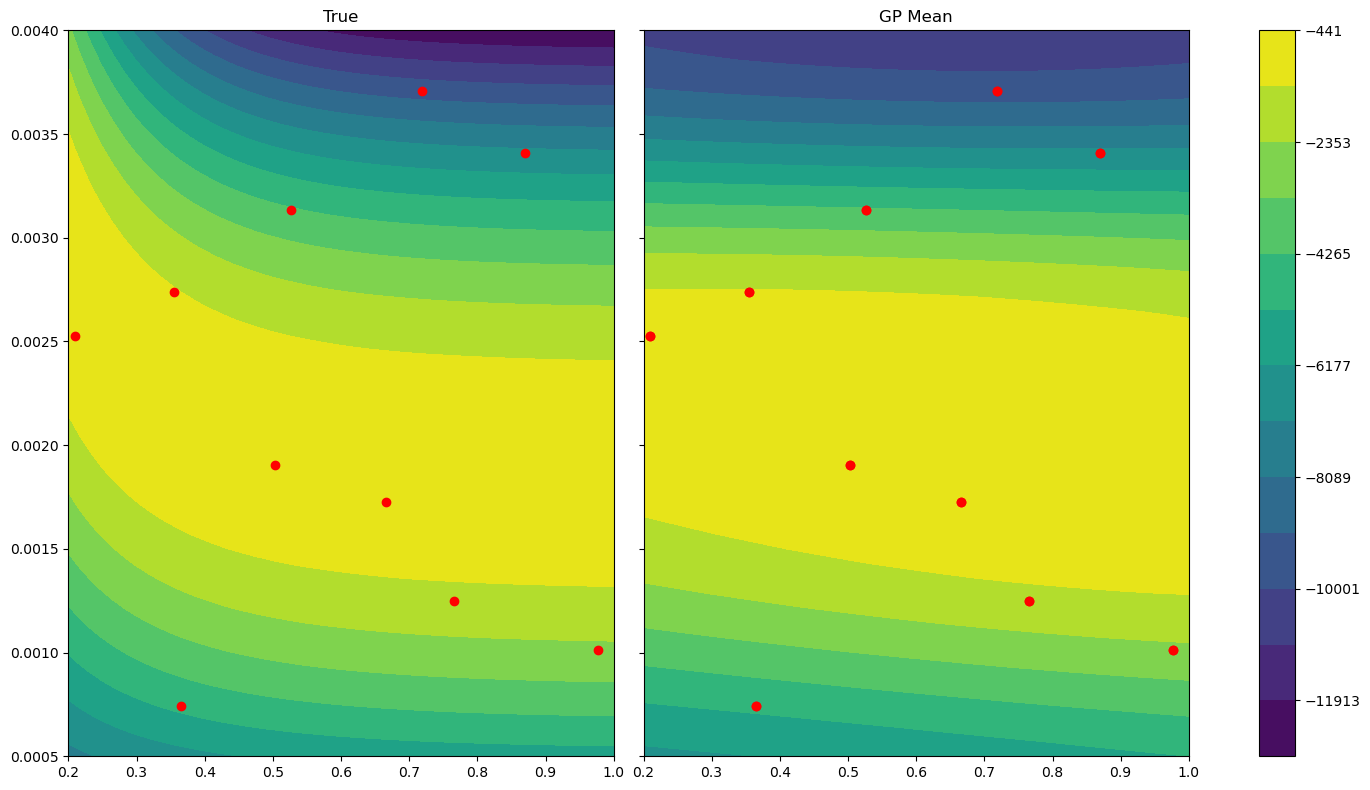

In [68]:
# GP predictive mean. 

for pred in pred_list:
    fig = plot_gp_fit_2d(x_grid, llik_test, pred["mean"], par_cal_design, n_levels, ["True", "GP Mean"])
    fig

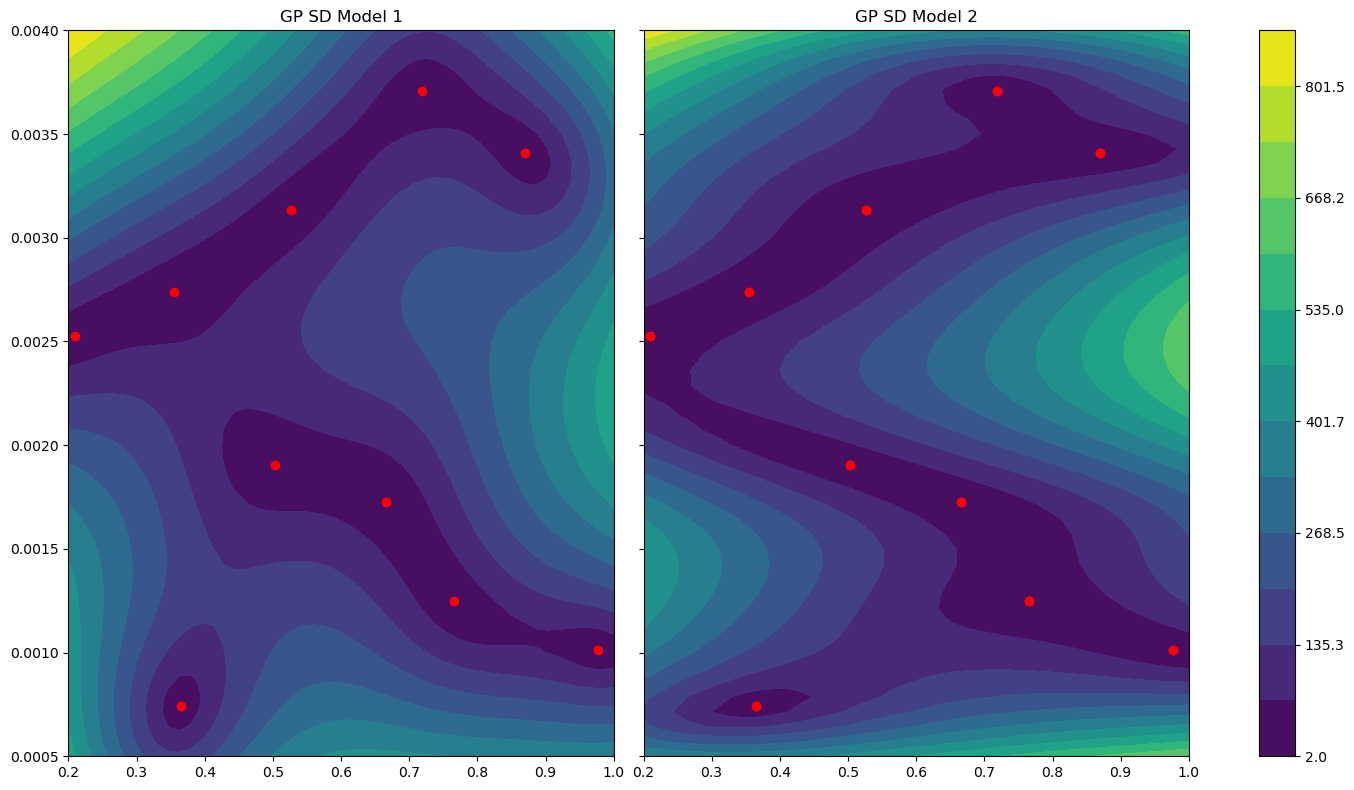

In [69]:
# GP predictive SD. 
fig_sd = plot_gp_fit_2d(x_grid, np.sqrt(pred_list[0]["var"]), np.sqrt(pred_list[1]["var"]), par_cal_design, 
                        n_levels, ["GP SD Model 1", "GP SD Model 2"])

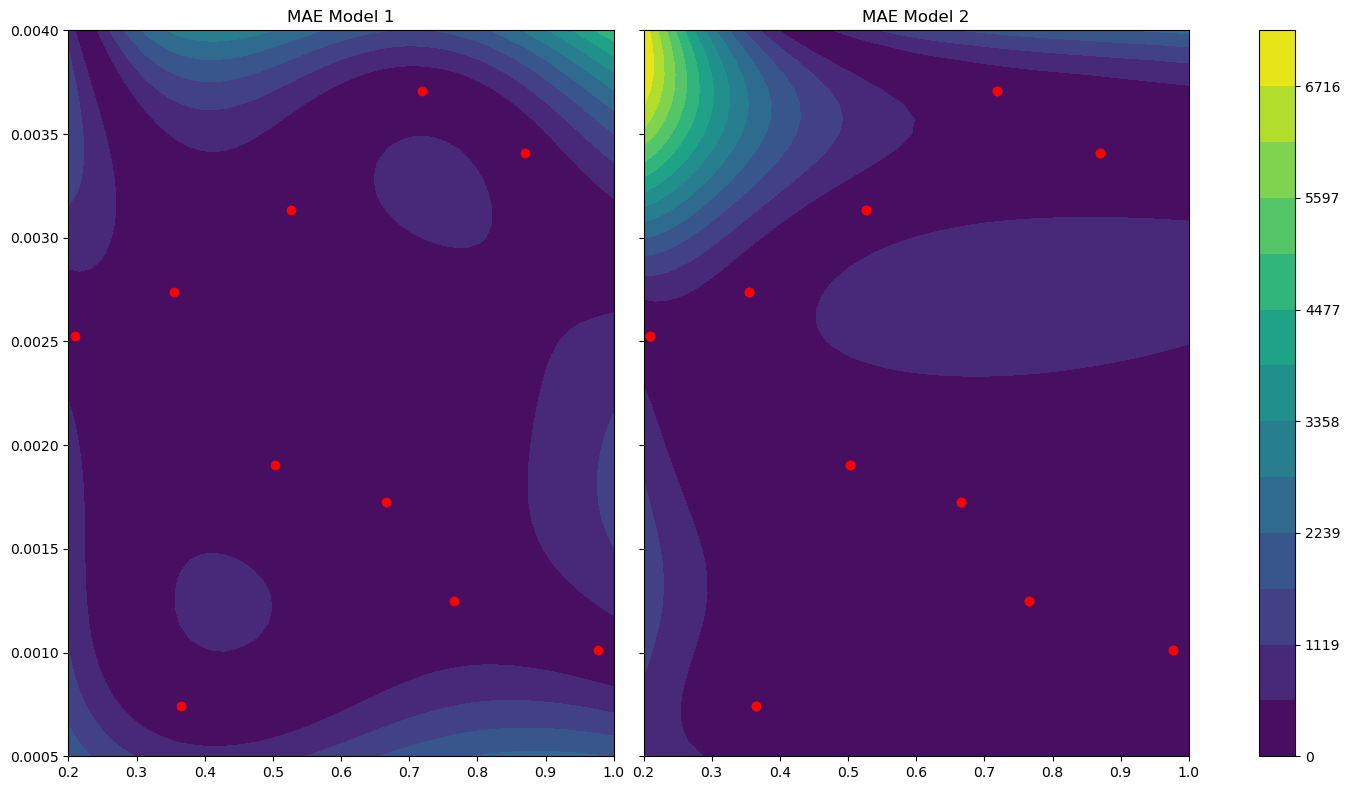

In [76]:
# GP MAE. 
fig_mae = plot_gp_fit_2d(x_grid, pred_list[0]["mae"], pred_list[1]["mae"], par_cal_design, 
                         n_levels, ["MAE Model 1", "MAE Model 2"])

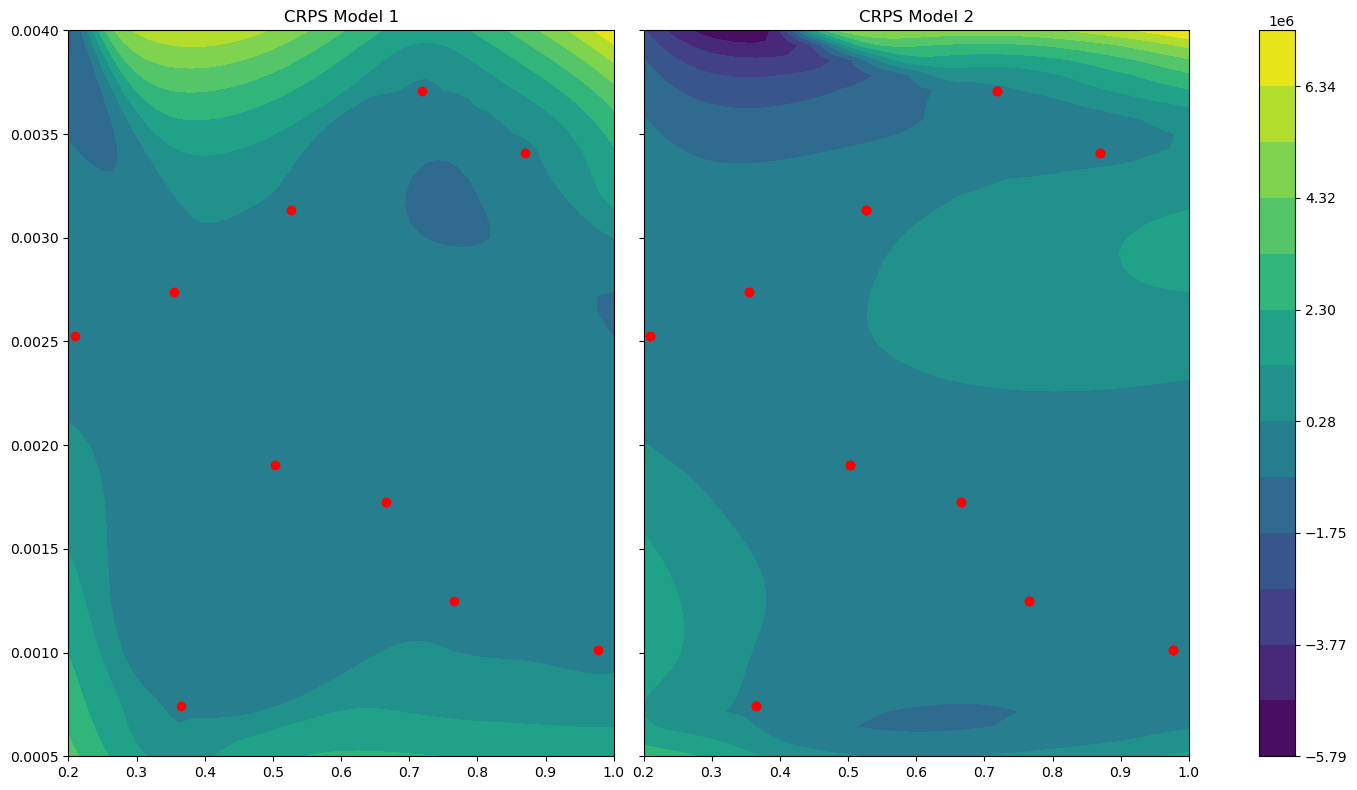

In [71]:
# GP CRPS. 
fig_crps = plot_gp_fit_2d(x_grid, pred_list[0]["crps"], pred_list[1]["crps"], par_cal_design, 
                          n_levels, ["CRPS Model 1", "CRPS Model 2"])

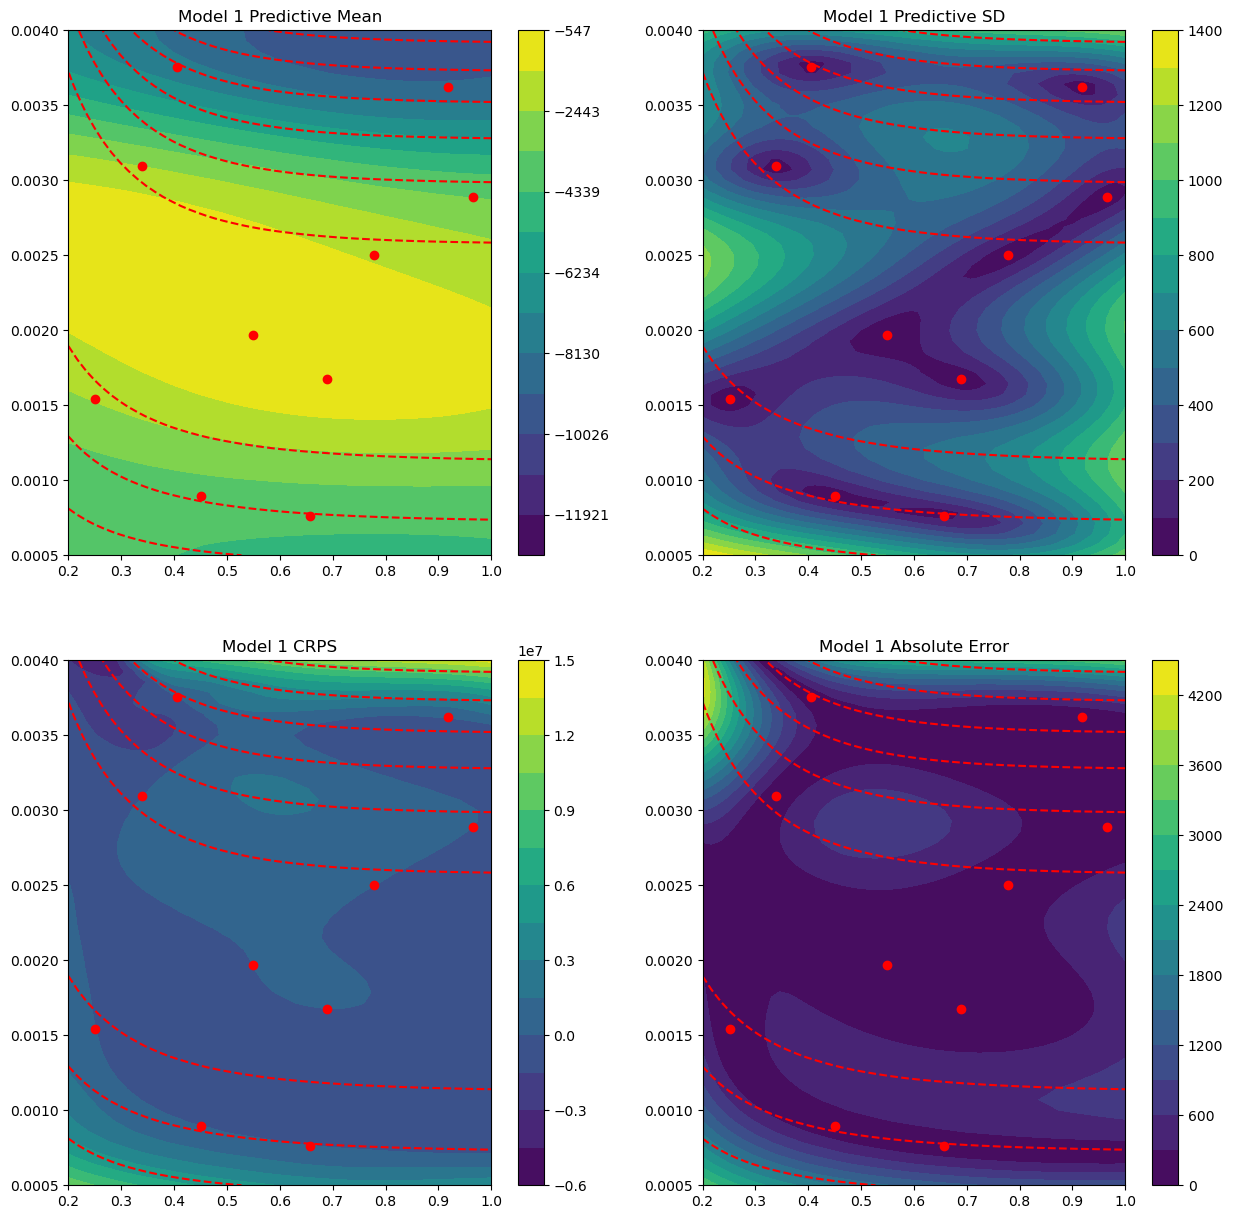

In [35]:
#
# Model 1
#

# Prediction contour plot.
fig = plt.figure()
fig.set_figwidth(15.0)
fig.set_figheight(15.0)
plt.subplot(2,2,1)
plt.contourf(x_grid[0], x_grid[1], pred_mean1.reshape(n_grid_1d, n_grid_1d), levels=levels)
plt.colorbar()
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d), colors="red")
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.title("Model 1 Predictive Mean")

plt.subplot(2,2,2)
plt.contourf(x_grid[0], x_grid[1], pred_sd1.reshape(n_grid_1d, n_grid_1d), levels=n_levels)         
plt.colorbar()
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d), colors="red")
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.title("Model 1 Predictive SD")

plt.subplot(2,2,3)
plt.contourf(x_grid[0], x_grid[1], crps1.reshape(n_grid_1d, n_grid_1d), levels=n_levels)
plt.colorbar()
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d), colors="red")
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.title("Model 1 CRPS")

plt.subplot(2,2,4)
plt.contourf(x_grid[0], x_grid[1], err1.reshape(n_grid_1d, n_grid_1d), 
             levels=14)
plt.colorbar()
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d), colors="red")
plt.title("Model 1 Absolute Error")

plt.show()
